In [38]:
import json
import os
import numpy as np
from joblib import Parallel, delayed
from scipy import sparse
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

In [39]:
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Ensure you download stopwords from NLTK if not already done
import nltk
nltk.download('stopwords')
nltk.download('punkt')

# Preprocessing function
def preprocess_text(text):
    # Lowercase the text
    text = text.lower()
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Tokenize and remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = word_tokenize(text)
    processed_text = ' '.join([word for word in tokens if word not in stop_words])
    return processed_text

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jaamiemaarshj/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/jaamiemaarshj/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [40]:
# Function to load data from .jsonl files efficiently with preprocessing
def _load_split(data_dir, source, split, n=np.inf):
    path = os.path.join(data_dir, f'{source}.{split}.jsonl')
    texts = []
    for i, line in enumerate(open(path)):
        if i >= n:  # Limit the number of examples if needed (use np.inf to load all)
            break
        # Preprocess each line's text
        text = json.loads(line)['text']
        texts.append(preprocess_text(text))
    return texts

# Combine human and machine-generated texts with preprocessing
def load_split(data_dir, source, split, n=np.inf):
    webtext = _load_split(data_dir, 'webtext', split, n=n//2)  # Human-generated text
    gen = _load_split(data_dir, source, split, n=n//2)         # Machine-generated text
    texts = webtext + gen
    labels = [0] * len(webtext) + [1] * len(gen)               # 0 = human, 1 = machine
    return texts, labels

In [41]:
data_dir

'data'

### Data Pre-Processing

In [42]:
# import pandas as pd
# # List all files in the data directory
# files = [f for f in os.listdir(data_dir) if f.endswith('.jsonl')]

# # Loop through each file and display content
# for file in files:
#     file_path = os.path.join(data_dir, file)
#     print(f"Contents of {file}:")
    
#     # Load the .jsonl file into a DataFrame and display the content
#     df = pd.read_json(file_path, lines=True)
#     print(df.head())  # Display the first few rows
#     print("\nColumns:", df.columns.tolist())  # Display the column names
#     print("-" * 40)  # Separator for readability

In [43]:
# Define function to process data in parallel using joblib
def parallel_tfidf_fit_transform(vectorizer, texts, n_splits=4):
    # Split data into smaller chunks for parallelization
    chunks = np.array_split(texts, n_splits)
    results = Parallel(n_jobs=-1)(delayed(vectorizer.fit_transform)(chunk) for chunk in chunks)
    return sparse.vstack(results)

In [44]:
data_dir = 'data'  # Directory where the data is stored
source = 'xl-1542M-k40'  # Source of the machine-generated text
n_train = 50000  # Number of training examples
n_valid = 1000   # Number of validation examples

In [45]:
# Load data
train_texts, train_labels = load_split(data_dir, source, 'train', n=n_train)
valid_texts, valid_labels = load_split(data_dir, source, 'valid', n=n_valid)
test_texts, test_labels = load_split(data_dir, source, 'test')

In [46]:
# Use TF-IDF to convert text to numeric features in parallel
vectorizer = TfidfVectorizer(ngram_range=(1, 2), min_df=5, max_features=2**21)

# Fit and transform training set in parallel
train_features = vectorizer.fit_transform(train_texts)
valid_features = vectorizer.transform(valid_texts)
test_features = vectorizer.transform(test_texts)

In [47]:
# After fitting the vectorizer
vocab_size = len(vectorizer.get_feature_names_out())
print(f"Vocabulary size: {vocab_size}")


Vocabulary size: 348941


In [48]:
import numpy as np

# Number of non-zero elements per row (per document)
avg_train_features = np.mean(np.diff(train_features.indptr))
print(f"Average number of non-zero features per document in training set: {avg_train_features}")


Average number of non-zero features per document in training set: 242.01514


In [49]:
# Get the top N tokens by frequency
top_n = 20
indices = np.argsort(np.array(train_features.sum(axis=0)).flatten())[::-1][:top_n]
feature_names = vectorizer.get_feature_names_out()
top_tokens = [(feature_names[i], train_features[:, i].sum()) for i in indices]
print("Top tokens (n-grams):", top_tokens)


Top tokens (n-grams): [('said', 919.0357282581798), ('new', 630.4795793616552), ('one', 591.1258560154918), ('people', 589.0578693777313), ('would', 554.208161502105), ('us', 525.4371407065015), ('also', 501.9719911971265), ('like', 481.11268641174627), ('time', 448.63476607997086), ('first', 433.0130768737822), ('get', 432.5231857698003), ('game', 422.44094213481674), ('police', 377.80488803149893), ('make', 377.4166828675743), ('two', 368.6994496581457), ('could', 354.23381975732786), ('dont', 342.7417002266656), ('use', 342.26480790408), ('trump', 340.2235869350459), ('years', 335.81818346028996)]


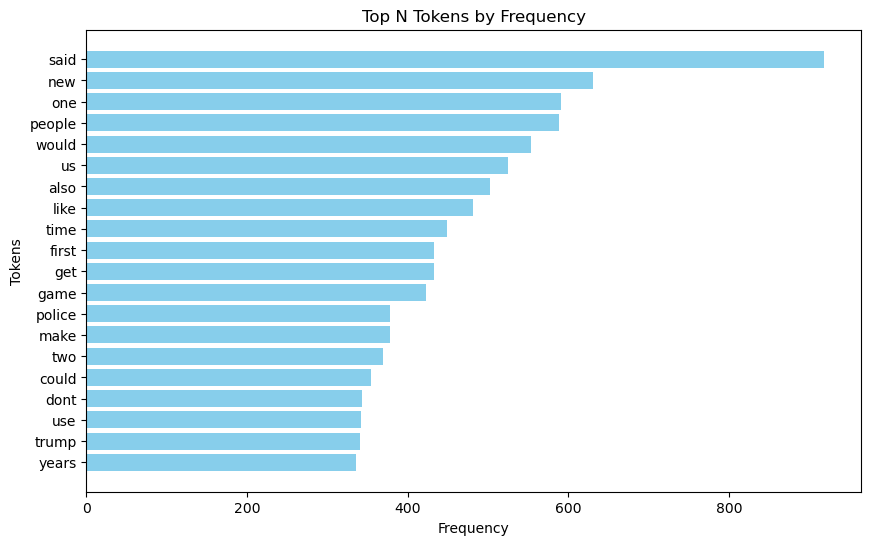

In [50]:
import matplotlib.pyplot as plt

# Plot top N tokens
top_n_tokens = [token for token, _ in top_tokens]
frequencies = [freq for _, freq in top_tokens]

plt.figure(figsize=(10, 6))
plt.barh(top_n_tokens, frequencies, color='skyblue')
plt.xlabel("Frequency")
plt.ylabel("Tokens")
plt.title("Top N Tokens by Frequency")
plt.gca().invert_yaxis()  # To show the highest on top
plt.show()


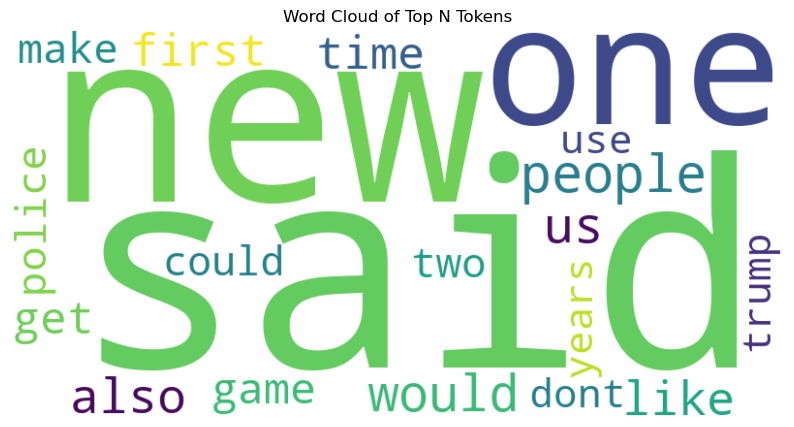

In [51]:
from wordcloud import WordCloud

# Generate a word cloud for the top tokens
word_freq = {token: freq for token, freq in top_tokens}
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Top N Tokens')
plt.show()


Ligistic Regression Model

In [52]:
# imports
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.metrics import accuracy_score, classification_report

In [53]:
# Set up Logistic Regression model
model = LogisticRegression(solver='liblinear')

In [54]:
# Define hyperparameter grid for tuning
params = {'C': [1/64, 1/32, 1/16, 1/8, 1/4, 1/2, 1, 2, 4, 8, 16, 32, 64]}

In [55]:
# Predefined split for cross-validation (use validation set for hyperparameter tuning)
split = PredefinedSplit([-1]*n_train+ [0]*n_valid)

In [56]:
# Use GridSearchCV to find the best hyperparameter 'C'
search = GridSearchCV(model, params, cv=split, n_jobs=-1, verbose=1, refit=False)
search.fit(sparse.vstack([train_features, valid_features]), train_labels + valid_labels)

Fitting 1 folds for each of 13 candidates, totalling 13 fits


python(18481) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(18482) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(18483) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(18484) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(18485) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(18486) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(18487) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(18488) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=LogisticRegression(solver='liblinear'), n_jobs=-1,
             param_grid={'C': [0.015625, 0.03125, 0.0625, 0.125, 0.25, 0.5, 1,
                               2, 4, 8, 16, 32, 64]},
             refit=False, verbose=1)

In [57]:
# Set best hyperparameters and refit the model on the full training set
model = model.set_params(**search.best_params_)
model.fit(train_features, train_labels)

LogisticRegression(C=16, solver='liblinear')

In [73]:
# Evaluate model on validation and test sets
# valid_accuracy = model.score(valid_features, valid_labels) * 100
# test_accuracy = model.score(test_features, test_labels) * 100

valid_accuracy = model.score(valid_features, valid_labels) 
test_accuracy = model.score(test_features, test_labels) 

# Print results
print(f'Validation Accuracy (Logistic Regression): {valid_accuracy * 100:.2f}%')
print(f'Test Accuracy (Logistic Regression): {test_accuracy * 100:.2f}%')


Validation Accuracy (Logistic Regression): 62.70%
Test Accuracy (Logistic Regression): 59.93%


In [59]:
# Print accuracy results
print(f'Validation Accuracy (Logistic Regression): {valid_accuracy:.2f}%')
print(f'Test Accuracy (Logistic Regression): {test_accuracy:.2f}%')

# Get classification report for the test set
test_predictions = model.predict(test_features)  # Predict labels for test set
classification_rep = classification_report(test_labels, test_predictions)

# Print classification report
print("\nClassification Report (Test Set):")
print(classification_rep)

Validation Accuracy (Logistic Regression): 84.20%
Test Accuracy (Logistic Regression): 84.28%

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.85      0.83      0.84      5000
           1       0.84      0.85      0.84      5000

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



In [60]:
# print results
data = {
    'source':source,
    'n_train':n_train,
    'valid_accuracy':valid_accuracy,
    'test_accuracy':test_accuracy
}
print(data)

{'source': 'xl-1542M-k40', 'n_train': 50000, 'valid_accuracy': 84.2, 'test_accuracy': 84.28}


Decision Tree Model Classification

In [61]:
from sklearn.tree import DecisionTreeClassifier

In [62]:
# Set up Decision Tree model
model = DecisionTreeClassifier(random_state=42)

In [63]:
# Define hyperparameter grid for tuning
# 'max_depth' controls the depth of the tree
params = {
    'max_depth': [None, 10, 20, 30, 40],  # Limits on tree depth
    'min_samples_split': [2, 10, 20],  # Minimum samples required to split an internal node
    'min_samples_leaf': [1, 5, 10]  # Minimum samples required to be at a leaf node
}

In [64]:
# Predefined split for cross-validation (use validation set for hyperparameter tuning)
split = PredefinedSplit([-1]*n_train + [0]*n_valid)

In [65]:
# Use GridSearchCV to find the best hyperparameters
search = GridSearchCV(model, params, cv=split, n_jobs=-1, verbose=1, refit=False)

# Fit the model on both the training and validation data
search.fit(sparse.vstack([train_features, valid_features]), train_labels + valid_labels)

Fitting 1 folds for each of 45 candidates, totalling 45 fits


GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20, 30, 40],
                         'min_samples_leaf': [1, 5, 10],
                         'min_samples_split': [2, 10, 20]},
             refit=False, verbose=1)

In [66]:
# Set the best parameters found by GridSearchCV
model = model.set_params(**search.best_params_)

# Fit the final model on the training set
model.fit(train_features, train_labels)

DecisionTreeClassifier(max_depth=10, min_samples_leaf=5, random_state=42)

In [67]:
# Evaluate the model on the validation set
valid_accuracy = model.score(valid_features, valid_labels) * 100
test_accuracy = model.score(test_features, test_labels) * 100

# Output results
print(f'Validation Accuracy (Decision Tree): {valid_accuracy:.2f}%')
print(f'Test Accuracy (Decision Tree): {test_accuracy:.2f}%')

# Classification report to provide more detailed metrics (precision, recall, F1-score)
print(classification_report(test_labels, model.predict(test_features)))

Validation Accuracy (Decision Tree): 63.60%
Test Accuracy (Decision Tree): 62.74%
              precision    recall  f1-score   support

           0       0.62      0.66      0.64      5000
           1       0.64      0.60      0.62      5000

    accuracy                           0.63     10000
   macro avg       0.63      0.63      0.63     10000
weighted avg       0.63      0.63      0.63     10000



K-Nearest Neighbors Classifier

In [68]:
from sklearn.neighbors import KNeighborsClassifier

In [69]:
# Set up KNN model
model = KNeighborsClassifier()

# Define hyperparameter grid for tuning
# 'n_neighbors' controls the number of neighbors considered
# 'weights' defines how neighbors influence the prediction (uniform or distance)
params = {
    'n_neighbors': [3, 5, 7, 9],  # Number of neighbors to use
    'weights': ['uniform', 'distance'],  # Weighting by distance or uniform weight
    'p': [1, 2]  # p=1 for Manhattan distance, p=2 for Euclidean distance
}

In [70]:
# Predefined split for cross-validation (use validation set for hyperparameter tuning)
split = PredefinedSplit([-1]*n_train + [0]*n_valid)

# Use GridSearchCV to find the best hyperparameters
search = GridSearchCV(model, params, cv=split, n_jobs=-1, verbose=1, refit=False)
# Fit the model on both the training and validation data
search.fit(sparse.vstack([train_features, valid_features]), train_labels + valid_labels)

Fitting 1 folds for each of 16 candidates, totalling 16 fits


/Users/jaamiemaarshj/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jaamiemaarshj/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/jaamiemaarshj/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 415, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/jaamiemaarshj/anaconda3/lib/python3.11/site-packages/sklearn/base.py", line 764, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
                             ^^^^^^^^^^^^^^^
  File "/Users/jaamiemaarshj/anaconda3/lib/python3.11/s

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [3, 5, 7, 9], 'p': [1, 2],
                         'weights': ['uniform', 'distance']},
             refit=False, verbose=1)

In [71]:
# Set the best parameters found by GridSearchCV
model = model.set_params(**search.best_params_)

# Fit the final model on the training set
model.fit(train_features, train_labels)

KNeighborsClassifier()

In [72]:
# Evaluate the model on the validation set
valid_accuracy = model.score(valid_features, valid_labels) * 100
test_accuracy = model.score(test_features, test_labels) * 100

# Output results
print(f'Validation Accuracy (KNN): {valid_accuracy:.2f}%')
print(f'Test Accuracy (KNN): {test_accuracy:.2f}%')

# Classification report to provide more detailed metrics (precision, recall, F1-score)
print(classification_report(test_labels, model.predict(test_features)))

Validation Accuracy (KNN): 62.70%
Test Accuracy (KNN): 59.93%
              precision    recall  f1-score   support

           0       0.67      0.40      0.50      5000
           1       0.57      0.80      0.67      5000

    accuracy                           0.60     10000
   macro avg       0.62      0.60      0.58     10000
weighted avg       0.62      0.60      0.58     10000

